# Projet CIFAR-10 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

1. Charger les données CIFAR-10

Le jeu de données CIFAR-10 contient 60 000 images couleur de taille 32x32 pixels, réparties équitablement en 10 classes, soit 6 000 images par classe. Dans le cadre de ce projet, nous nous concentrons exclusivement sur les classes représentant des animaux : oiseau, chat, cerf, chien, grenouille et cheval — soit un total de 6 classes. Chaque image est en couleur, avec 3 canaux (Rouge, Vert, Bleu) pour représenter les pixels.

Dans cette section, nous allons présenter en détail le processus d’analyse exploratoire ainsi que les étapes de prétraitement des données.

Le dataset est chargé à l’aide de l’API Keras, en deux ensembles distincts : ensemble d’entraînement et ensemble de test, conformément aux bonnes pratiques de séparation des données pour entraîner et évaluer un modèle. Par la suite, nous filtrons les données afin de ne conserver que les images correspondant aux classes animales.

In [28]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

2. Dictionnaire des labels CIFAR-10

In [29]:
label_names = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

3. Définit les noms des classes et les classes d'animaux uniquement : bird, cat, deer, dog, frog, horse.

In [30]:
animal_labels = [2, 3, 4, 5, 6, 7]
def filter_animals(x, y):
    mask = np.isin(y, animal_labels)
    x_animal = x[mask]
    y_animal = y[mask]
    y_animal = np.array([animal_labels.index(label) for label in y_animal])
    return x_animal, y_animal


x_train, y_train = filter_animals(x_train, y_train)
x_test, y_test = filter_animals(x_test, y_test)

print(f"train : { x_train.shape[0]} images")
print(f"test : { x_test.shape[0]} images")


train : 30000 images
test : 6000 images



4. Normalisation des données

In [31]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print("Taille des images :", x_train[0].shape)

Taille des images : (32, 32, 3)


In [38]:

x_full = np.concatenate([x_train, x_test], axis=0)
y_full = np.concatenate([y_train, y_test], axis=0)

print(f"Full dataset : {x_full.shape[0]} images")

zoo_mask = np.isin(y_full, animal_labels).flatten()

x_zoo=x_full[zoo_mask]
y_zoo=y_full[zoo_mask]

print(f"Images d'animaux : {x_zoo.shape[0]}")
print(f"Shape : {x_zoo.shape}, Labels : {y_zoo.shape}")


Full dataset : 36000 images
Images d'animaux : 24000
Shape : (24000, 32, 32, 3), Labels : (24000,)


5. Affiche une image de chaque classe animale à l'aide de matplotlib

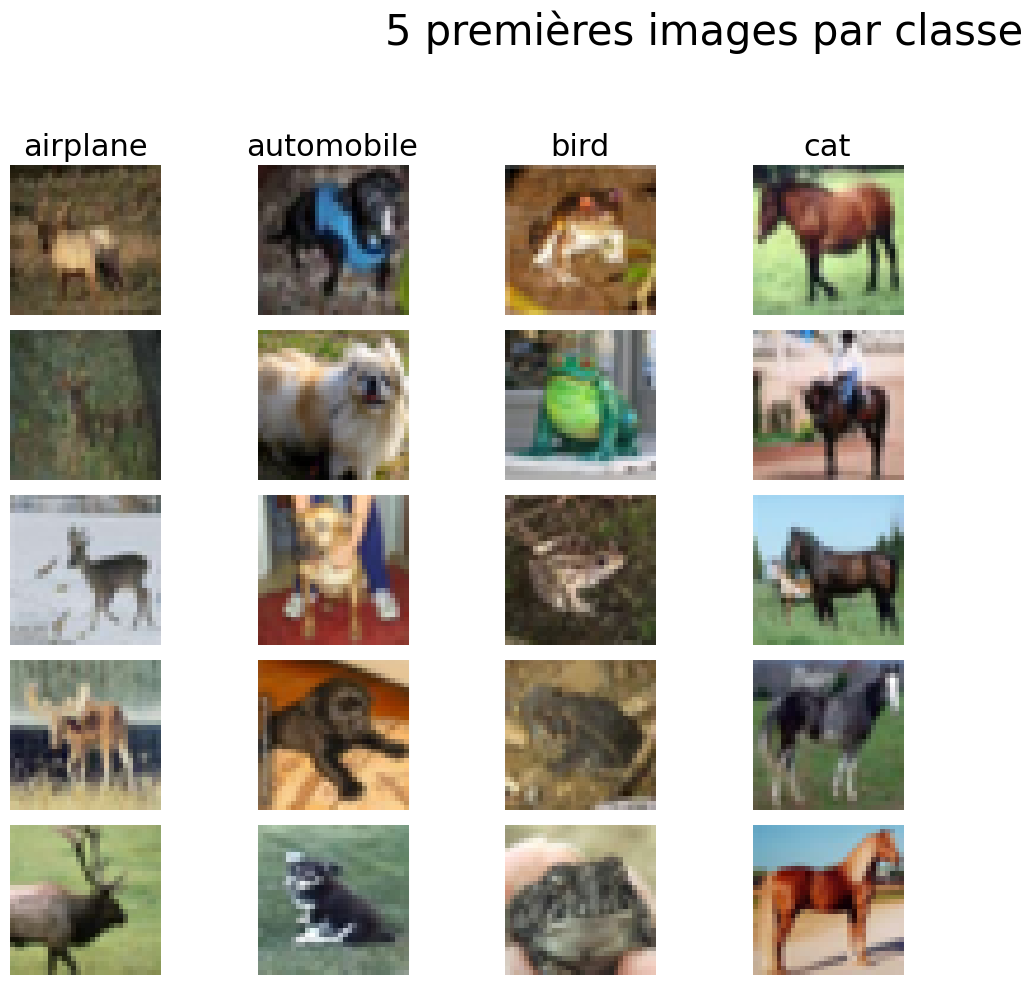

In [39]:
plt.figure(figsize=(15, 10))
plt.suptitle("5 premières images par classe", fontsize=30)

images_per_class = 5

for col, class_id in enumerate(animal_labels):
    class_indices = np.where(y_zoo == class_id)[0][:images_per_class]
    
    for row, idx in enumerate(class_indices):
        plt_idx = row * len(animal_labels) + col + 1
        plt.subplot(images_per_class, len(animal_labels), plt_idx)
        plt.imshow(x_zoo[idx])
        plt.axis('off')
        
        if row == 0:
            plt.title(label_names[col], fontsize=22)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [42]:
print("Moyenne :", np.mean(x_zoo, axis=(0, 1, 2)))
print("Écart type :", np.std(x_zoo, axis=(0, 1, 2)))

Moyenne : [0.48633423 0.46250534 0.3896482 ]
Écart type : [0.2357577  0.22917105 0.23588073]


La moyenne de chaque canal (rouge, vert, bleu) reflète l’intensité lumineuse moyenne des couleurs dans l’ensemble des images. On observe que le canal rouge présente une intensité légèrement supérieure à celle des autres, suivi du vert, puis du bleu.

L’écart type, quant à lui, mesure la variabilité des intensités dans chaque canal. Les valeurs obtenues, proches de 60 pour les trois canaux, indiquent une dispersion similaire des couleurs, suggérant que chaque canal couvre une large gamme de valeurs.

Ces caractéristiques traduisent la diversité des scènes présentes dans le jeu de données, avec des animaux représentés dans des environnements variés. Cette diversité est favorable à l’apprentissage d’un modèle robuste, car elle encourage le modèle à généraliser plutôt qu’à mémoriser des contextes spécifiques.

In [ ]:
x_animals_reshaped = x_zoo.reshape((x_zoo.shape[0], -1))
_, unique_idx = np.unique(x_animals_reshaped, axis=0, return_index=True)
duplicates = x_zoo.shape[0] - len(unique_idx)

print(f"Nombre de doublons exacts : {duplicates}")

Nombre de doublons exacts : 0


In [15]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

Fonction pour afficher la répartition des classes

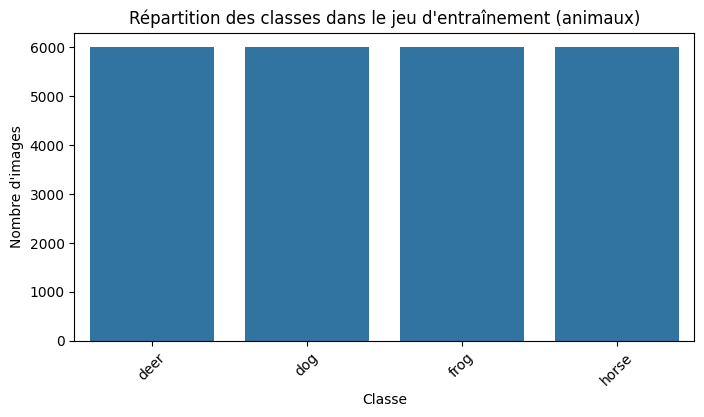

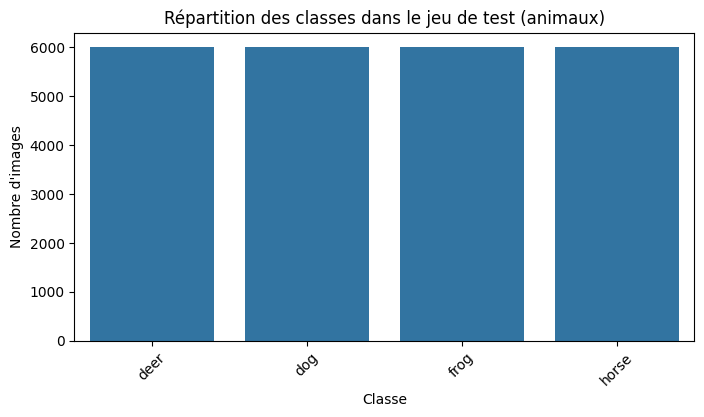

In [44]:
def plot_class_distribution(y, label_names, title):
    unique, counts = np.unique(y_zoo, return_counts=True)
    labels = [label_names[animal_labels[i]] for i in unique]
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=labels, y=counts)
    plt.title(title)
    plt.ylabel("Nombre d'images")
    plt.xlabel("Classe")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(y_zoo, label_names, "Répartition des classes dans le jeu d'entraînement (animaux)")
plot_class_distribution(y_zoo, label_names, "Répartition des classes dans le jeu de test (animaux)")


Les classes sont réparties de manières équilibré. Environ 600 images par classe en entrainement et 6000 images par classe en test

distribution GRB

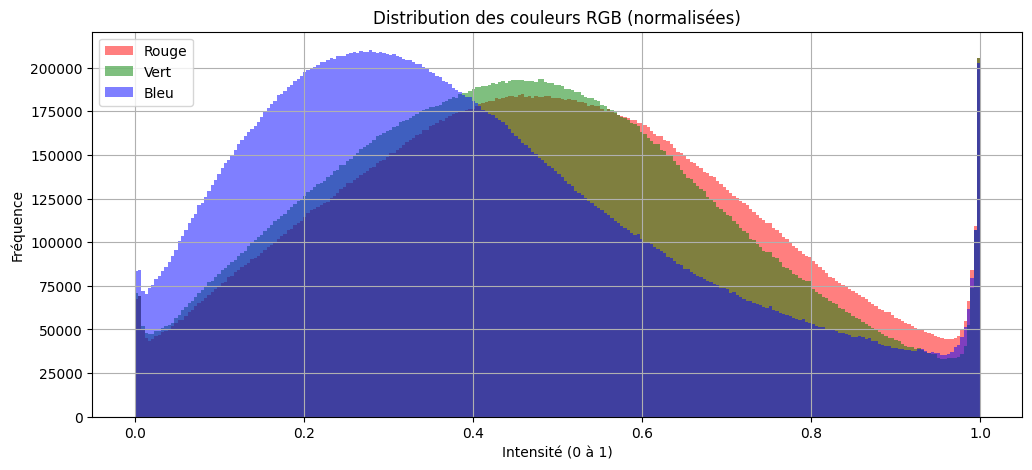

In [45]:
r_vals = x_train[:, :, :, 0].flatten()
g_vals = x_train[:, :, :, 1].flatten()
b_vals = x_train[:, :, :, 2].flatten()

plt.figure(figsize=(12, 5))

plt.hist(r_vals, bins=256, color='red', alpha=0.5, label='Rouge')
plt.hist(g_vals, bins=256, color='green', alpha=0.5, label='Vert')
plt.hist(b_vals, bins=256, color='blue', alpha=0.5, label='Bleu')

plt.title("Distribution des couleurs RGB (normalisées)")
plt.xlabel("Intensité (0 à 1)")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(True)
plt.show()

7. Perceptron multi couche

In [ ]:
mlp_model = models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(6, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp_history = mlp_model.fit(x_zoo, y_zoo, validation_split=0.2, epochs=10, batch_size=64)

C:\Users\Dorène\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.3536 - loss: 1.6711 - val_accuracy: 0.4063 - val_loss: 1.5066
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4484 - loss: 1.4063 - val_accuracy: 0.3152 - val_loss: 1.8261
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.4730 - loss: 1.3479 - val_accuracy: 0.3963 - val_loss: 1.6077
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4885 - loss: 1.3061 - val_accuracy: 0.4303 - val_loss: 1.4507
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5010 - loss: 1.2808 - val_accuracy: 0.3952 - val_loss: 1.5362
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5152 - loss: 1.2526 - val_accuracy: 0.3790 - val_loss: 1.7345
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5297 - loss: 1.2265 - val_accuracy: 0.3450 - val_loss: 1.9775
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5415 - loss: 1.1950 - val_acc

Perceptron multi couche :
Le flatten convertis l'image plusieurs vecteurs de taille, ensuite nous avons les deux couches Linear suivies de BatchNorm + ReLU.
et une couche de sortie avec 6 classes d'animaux uniquement.

La loss diminue progressimevent au cours des epoch; le modèle apprend progressivement?

# 8 . CNN

In [19]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(6, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(x_train, y_train_cat, validation_split=0.2, epochs=10, batch_size=64)

C:\Users\Dorène\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 144ms/step - accuracy: 0.4633 - loss: 1.4863 - val_accuracy: 0.1888 - val_loss: 27.2173
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 135ms/step - accuracy: 0.6672 - loss: 0.9045 - val_accuracy: 0.5498 - val_loss: 1.2474
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 136ms/step - accuracy: 0.7600 - loss: 0.6636 - val_accuracy: 0.4720 - val_loss: 2.7315
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 136ms/step - accuracy: 0.8464 - loss: 0.4414 - val_accuracy: 0.5878 - val_loss: 1.2631
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 135ms/step - accuracy: 0.9371 - loss: 0.2174 - val_accuracy: 0.6087 - val_loss: 1.3694
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 136ms/step - accuracy: 0.9735 - loss: 0.1046 - val_accuracy: 0.6470 - val_loss: 1.3705
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 136ms/step - accuracy: 0.9909 - loss: 0.0470 - val_accuracy: 0.6552 - val_loss: 1.4211
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 53s 140ms/step - accuracy: 0.9931 - loss: 

# 9. Evaluation et matrice de confusion

In [ ]:
def evaluate_keras_model(model, x_test, y_test, name="Modèle"):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    print(f"\nRapport de classification ({name}):")
    print(classification_report(y_test, y_pred, target_names=[label_names[i] for i in animal_labels]))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_names[i] for i in animal_labels],
                yticklabels=[label_names[i] for i in animal_labels])
    plt.title(f"Matrice de confusion ({name})")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

evaluate_keras_model(mlp_model, x_test, y_test, name="MLP")
evaluate_keras_model(cnn_model, x_test, y_test, name="CNN")

# 10. Courbes d'apprentissage

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Perte')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Précision')
    plt.legend()
    
    plt.suptitle(title)
    plt.show()

plot_history(mlp_history, "MLP")
plot_history(cnn_history, "CNN")


La différence entre MLP et CNN  n'est pas claire
je ne comprend pas  comment les couches de convolution extraient les caractéristiques spatiales.